In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations
import pandas as pd
import time
from numba import jit
from functools import lru_cache

## Rao-Blackwellization of the Accept-Reject algorithm

Accept rate: 28.12%


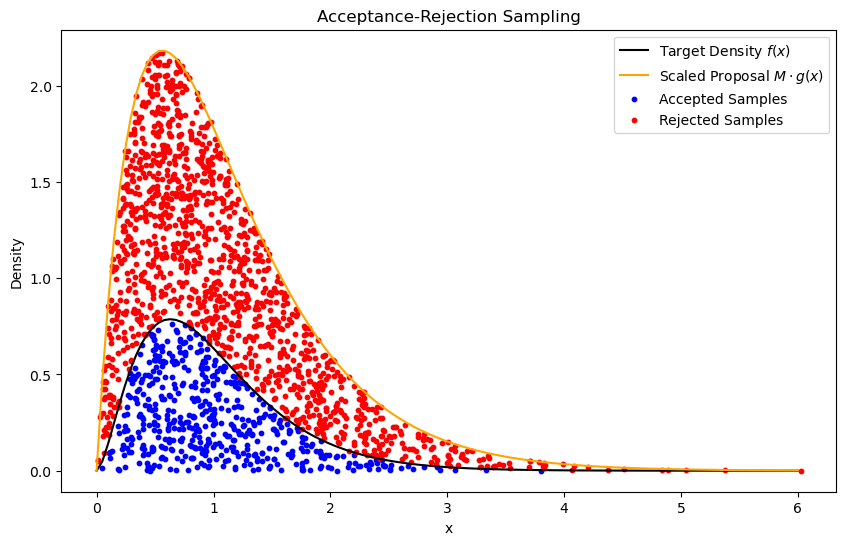

In [3]:
# Define distributions
f = stats.gamma(2.70, scale=1 / 2.70)
g = stats.gamma(2,scale=1/1.78)
#g = stats.uniform(0, 6)

# Parameters
n = 500
M = 1/0.3  # M = 1/Acceptance_rate

# Storage for accepted and rejected samples
acceptx, rejetx = [], []
accepty, rejety = [], []

# Generate samples using Accept-Reject method
while len(acceptx) < n:
    y = g.rvs()
    u = np.random.uniform()
    if u < f.pdf(y) / (M * g.pdf(y)):
        acceptx.append(y)
        accepty.append(u * M * g.pdf(y))
    else: 
        rejetx.append(y)
        rejety.append(u * M * g.pdf(y))

# Plot the results
xx = np.linspace(0, 6, 125)
accept_rate = 100 * len(acceptx) / (len(acceptx) + len(rejetx))
print(f"Accept rate: {accept_rate:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(xx, f.pdf(xx), label=r'Target Density $f(x)$', color='black')
plt.plot(xx, M * g.pdf(xx), label=r'Scaled Proposal $M \cdot g(x)$', color='orange')
plt.scatter(acceptx, accepty, color='blue', s=10, label='Accepted Samples')
plt.scatter(rejetx, rejety, color='red', s=10, label='Rejected Samples')

# Add title and labels
plt.title("Acceptance-Rejection Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()


#### Optimized version of the Accept-Reject Algorithm 
This versions takes advantage of numpy vectorization to generate the maximum amount of random variable needed and do every computations all at once. The 'remaining_needed' variable adjust itself to ensure that we are not generating wasted random variables. 

In [5]:
#Simulation of the accepted and proposed sample using AR 
def Accept_Reject(t,M):
    sample_accept = []  
    sample_proposal = []  
    while len(sample_accept) < t:
        
        # Calculate the required batch size based on remaining needed samples
        remaining_needed = t - len(sample_accept)
        batch_size = remaining_needed
        
        y = g.rvs(size=batch_size)
        u = np.random.uniform(size=batch_size)
        
        # Calculate acceptance condition in bulk
        accepted = u < f.pdf(y) / (M * g.pdf(y))
        
        # Append all proposals to sample_proposal and only accepted ones to sample_accept
        sample_proposal.extend(y)
        sample_accept.extend(y[accepted])

    return sample_accept, sample_proposal

### Naïve Implementation of the Rao-Blackwellized estimator (with the permutation) 
This is the code for the non-recursive version of p_i of the which is very (very) slow to compute because of the permutations. Try to keep the parameters  low and the acceptance rate, or else it will take a very long time to compute ! 

In [7]:
#Parameters 
number_of_samples = 100
t = 4 #Size of the accepted sample # Keep it low  
M = 1/0.3  # M = 1/acceptance_rate

samples_accept = []
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = Accept_Reject(t,M)
    samples_accept.append(accept)
    samples_proposal.append(proposal)

start_time = time.time()
compteur = 0 
res = []
for j in range(len(samples_proposal)) : 
    sample = samples_proposal[j]
    est = 0 
    sample_array = np.array(sample)
    n = len(sample) 
    weights = f.pdf(sample_array) / (M * g.pdf(sample_array))

    #Calculate denominator
    den = 0
    indices = np.array([idx for idx in range(n-1)])
    for comb in combinations(indices, t-1):
        selected_indices = list(comb)
        selected_weights = weights[selected_indices]
        complement_indices = [x for x in indices if x not in selected_indices]
        complement_weights = weights[complement_indices]
        den += np.prod(selected_weights) * np.prod(1 - complement_weights)
     
    for i in range(n-1):

        #Calculate numerator
        num = 0
        indices = np.array([idx for idx in range(n-1) if idx != i])
        for comb in combinations(indices, t-2):
            selected_indices = list(comb)
            selected_weights = weights[selected_indices]
            complement_indices = [x for x in indices if x not in selected_indices]
            complement_weights = weights[complement_indices]
            num += weights[i] * np.prod(selected_weights) * np.prod(1 - complement_weights)

        est+= (num/den)*sample_array[i]/t 
    est+= sample_array[n-1]/t 
    res.append(est)
    print(f"Progress: {100*(compteur+1)/len(samples_proposal)}%", end='\r')
    compteur+=1

end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

print("")        
# Empirical mean and variance calculations
samples_mean = [np.mean(x) for x in samples_accept]
true_mean = 1

print(f"Target mean: {true_mean}")
print(f"Acceptance Rate: {100*(1/M):.2f}%\n")
print(f"Classic MC empirical average mean: {np.mean(samples_mean):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res):.5f}\n")
print(f"Classic MC variance of the empirical mean: {np.var(samples_mean):.5f}")
print(f"Rao-Blackwell variance empirical mean: {np.var(res):.5f}\n")

classic_mc_mse = np.mean((np.array(samples_mean) - true_mean)**2)
rao_blackwell_mse = np.mean((np.array(res) - true_mean)**2)
mse_decrease = classic_mc_mse - rao_blackwell_mse
percent_decrease = (mse_decrease / classic_mc_mse) * 100

print(f"Classic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Percentage decrease in MSE: {percent_decrease:.2f}%")
print(" ")
print(f"Average time to compute : {loop_time}s")

Progress: 100.0%
Target mean: 1
Acceptance Rate: 30.00%

Classic MC empirical average mean: 1.04017
Rao-Blackwell empirical average mean: 1.01127

Classic MC variance of the empirical mean: 0.10980
Rao-Blackwell variance empirical mean: 0.04454

Classic MC MSE: 0.11141
Rao-Blackwell MSE: 0.04467
Percentage decrease in MSE: 59.91%
 
Average time to compute : 0.018274915218353272s


### Recursive Implementation of the Rao-Blackwellized estimator 
#### First recursive implementation, faster than the function using permutation but still quite slow.

In [9]:
#Rao-Blackwellized estimator computed using the recursive sequence 
#No numpy used because numpy array cannot be cached, and this function is very slow without caching 
@lru_cache(maxsize=None)
def w_i(y):
    if isinstance(y, tuple):
        y = np.array(y)  # Convert tuple back to array if passed as a tuple
    return f.pdf(y) / (M * g.pdf(y))


@lru_cache(maxsize=None)
def S(k, m, sample_hash):
    # Convert hash back to array for processing, if passed as a tuple
    sample = np.array(sample_hash) if isinstance(sample_hash, tuple) else sample_hash

    if k == 0:
        temp = 1
        for j in range(m):
            temp *= (1 - w_i(sample[j]))
        return temp

    if k == m:
        temp = 1
        for j in range(m):
            temp *= w_i(sample[j])
        return temp

    return (w_i(sample[m-1]) * S(k-1, m-1, tuple(sample)) +
            (1 - w_i(sample[m-1])) * S(k, m-1, tuple(sample)))


def clear_cache():
    w_i.cache_clear()
    S.cache_clear()



# Parameters 
number_of_samples = 100
t = 20  # Size of the accepted sample
M = 1/0.8 # M = 1/Acceptance_Rate 

#Generate AR samples
samples_accept = []
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = Accept_Reject(t, M)
    samples_accept.append(accept)
    samples_proposal.append(proposal)


samples = samples_proposal
start_time = time.time()
res = []
for j,sample in enumerate(samples):
    estimateur = 0
    sample_tuple1 = tuple(sample)
    n = len(sample)
    denominator = S(t-1, n-1, sample_tuple1)
    for i in range(n-1):    
        sample_tuple2 = tuple(np.delete(sample,i)) #Sample without Y_i 
        numerator = w_i(sample[i])*S(t-2, n-2, sample_tuple2)
        estimateur+= (numerator / denominator)*sample[i]/t
    estimateur+= sample[n-1]/t
    res.append(estimateur)
    clear_cache() #To avoid memory overflow
    print(f"Progress: {100*(j+1)/len(samples)}%", end='\r')

end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

samples_mean = [np.mean(x) for x in samples_proposal] 

print("")
true_mean = 1
print(f"target mean : {true_mean}")
print(f"Classic MC empirical average mean : {np.mean(samples_mean)}")
print(f"Rao Blackwell empirical average mean : {np.mean(res)}")
print("")
print(f"Classic MC variance of the empirical mean : {np.var(samples_mean)}")
print(f"Rao Blackwell variance empirical mean : {np.var(res)}")
print("")
classic_mc_mse = np.mean((np.array(samples_mean) - true_mean)**2)
rao_blackwell_mse = np.mean((np.array(res) - true_mean)**2)
print(f"Classic MC MSE : {classic_mc_mse}")
print(f"Rao Blackwell MSE : {rao_blackwell_mse}")
mse_decrease = classic_mc_mse - rao_blackwell_mse
percent_decrease = (mse_decrease / classic_mc_mse) * 100
print(f"Decrease in MSE: {mse_decrease}")
print(f"Percentage decrease in MSE: {percent_decrease:.2f}%")

print(" ")
print(f"Average time to compute : {loop_time}s")

Progress: 100.0%
target mean : 1
Classic MC empirical average mean : 1.1276257348954997
Rao Blackwell empirical average mean : 1.0071524437306436

Classic MC variance of the empirical mean : 0.026728862075586345
Rao Blackwell variance empirical mean : 0.013210217101262878

Classic MC MSE : 0.04301719028320273
Rao Blackwell MSE : 0.013261374552582899
Decrease in MSE: 0.02975581573061983
Percentage decrease in MSE: 69.17%
 
Average time to compute : 0.014471426010131835s


#### Optimized implementation using Matrix : 
This version is much faster, takes full advantage of Numpy and jit to speed up the process

In [11]:
@jit(nopython=True)
def iterative_S(n, t, weights):
    S_matrix = np.zeros((t+1, n))
    S_matrix[0, :] = 1  # Base case for k=0
    
    for m in range(1, n+1):
        weight_m1 = weights[m-1]

        #Multiply last columns by w_m to get new columns
        S_matrix[:, m] = S_matrix[:, m-1] * (1 - weight_m1)

        #add the product of the last column, shifted by 1 toward the bottom, by 1-w_m to the new columns
        S_matrix[1:t+1, m] += weight_m1 * S_matrix[:t, m-1]
        
    return S_matrix


def Rao_Blackwell_estimator_tau2(sample, t, M, f, g):
    n = len(sample)
    weights = f.pdf(sample) / (M * g.pdf(sample))
    
    # Compute S matrix of size (t,n) with iterative_S function
    S_matrix = iterative_S(n, t-1, weights)

    #The result is given by the value on the bottom right of the matrix
    denominator = S_matrix[t-1, n-1]

    # Initialize estimator with the last element's contribution
    estimator = sample[-1] / t
    
    
    for i in range(n-1):
        # Remove Y_i to calculate S^i_k(m) 
        sub_weights = np.delete(weights, i)
        sub_S_matrix = iterative_S(n-1, t-2, sub_weights)
        
        numerator = weights[i] * sub_S_matrix[t-2, n-2]
        estimator += (numerator / denominator) * sample[i] / t

    return estimator

In [12]:
# Parameters 
number_of_samples = 100
t = 50  # Size of the accepted sample
M = 1/0.5 # M = 1/Acceptance_Rate 

#Generate AR samples
samples_accept = []
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = Accept_Reject(t, M)
    samples_accept.append(accept)
    samples_proposal.append(proposal)

start_time = time.time()
#Compute RB estimator
res = []
for j, sample in enumerate(samples_proposal):
    res.append(Rao_Blackwell_estimator_tau2(sample,t,M,f,g))
    print(f"Progress: {100 * (j + 1) / len(samples_proposal):.2f}%", end='\r')


end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples
# Compute Statistics
samples_mean = [np.mean(x) for x in samples_accept]
true_mean = 1

print("")
print(f"Target mean: {true_mean:.5f}")
print(f"Acceptance Rate: {100*(1/M):.2f}%\n")
print(f"Classic MC empirical average mean: {np.mean(samples_mean):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res):.5f}\n")
print(f"Classic MC variance of the empirical mean: {np.var(samples_mean):.5f}")
print(f"Rao-Blackwell variance empirical mean: {np.var(res):.5f}\n")

classic_mc_mse = np.mean((np.array(samples_mean) - true_mean)**2)
rao_blackwell_mse = np.mean((np.array(res) - true_mean)**2)
mse_decrease = classic_mc_mse - rao_blackwell_mse
percent_decrease = (mse_decrease / classic_mc_mse) * 100

print(f"Classic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Percentage decrease in MSE: {percent_decrease:.2f}%")
print(" ")
print(f"Average time to compute : {loop_time}s")

Progress: 100.00%
Target mean: 1.00000
Acceptance Rate: 50.00%

Classic MC empirical average mean: 0.99746
Rao-Blackwell empirical average mean: 0.99876

Classic MC variance of the empirical mean: 0.00839
Rao-Blackwell variance empirical mean: 0.00320

Classic MC MSE: 0.00839
Rao-Blackwell MSE: 0.00320
Percentage decrease in MSE: 61.87%
 
Average time to compute : 0.007208237648010254s


## Comparative Analysis of Estimation Techniques: Classic Monte Carlo and Rao-Blackwell :

In [14]:
# Parameters
sample_sizes = [5, 10, 15, 20, 30, 40, 50, 100]
number_of_samples = 1000
true_mean = 1
M_values = [1/0.8, 1/0.3]

# Matrices to store statistics for each M value
Matrix_res_08 = np.zeros((len(sample_sizes), 5))  # For M = 1/0.8
Matrix_res_03 = np.zeros((len(sample_sizes), 5))  # For M = 1/0.3

# Loop over each M value
for M_index, M in enumerate(M_values):
    result_matrix = Matrix_res_08 if M_index == 0 else Matrix_res_03  # Select correct matrix

    for c, t in enumerate(sample_sizes):  # Loop over different sample sizes
        res_RB = []

        # Generate samples of size t
        samples_accept = []
        samples_proposal = []
        for _ in range(number_of_samples):
            accept, proposal = Accept_Reject(t, M)
            samples_accept.append(accept)
            samples_proposal.append(proposal)

        # Compute tau1 (classic MC estimator)
        res_MC = [np.mean(x) for x in samples_accept]

        # Compute tau2 (Rao-Blackwell estimator)
        for j, sample in enumerate(samples_proposal):
            res_RB.append(Rao_Blackwell_estimator_tau2(sample, t, M, f, g))

            # Progress display
            progress_message = f"Acceptance rate={1/M:.2f}, Size={t}, Progress: {100 * (j + 1) / number_of_samples:.2f}%"
            print(progress_message.ljust(60), end='\r')

        # Compute statistics
        result_matrix[c, 0] = np.mean(res_MC)  # Mean of classic MC results
        result_matrix[c, 1] = np.mean(res_RB)  # Mean of Rao-Blackwell results

        classic_mc_mse = np.mean((np.array(res_MC) - true_mean)**2)
        rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean)**2)

        result_matrix[c, 2] = classic_mc_mse
        result_matrix[c, 3] = rao_blackwell_mse

        # Compute MSE reduction
        mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
        percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100 if classic_mc_mse > 0 else 0
        result_matrix[c, 4] = percent_decrease_rb



#### Estimation of a gamma mean = 1, using Accept-Reject with acceptance rate 0.8 based on 10000 simulations

In [16]:
results = [
    'AR estimate',
    'RB estimate',
    'AR MSE',
    'RB MSE',
    'Decrease in MSE (%)']

df_results = pd.DataFrame(Matrix_res_08, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,AR estimate,RB estimate,AR MSE,RB MSE,Decrease in MSE (%)
Sample size,,,,,
5,0.99057,0.98923,0.07527,0.05925,21.28483
10,0.98945,0.99451,0.03774,0.02643,29.97197
15,0.99697,0.99576,0.02379,0.01708,28.18150
20,0.99489,0.99701,0.01873,0.01348,28.00503
30,0.99866,1.00133,0.01175,0.00819,30.31423
40,1.00123,0.99999,0.00940,0.00602,35.97384
50,1.00354,1.00298,0.00751,0.00493,34.36945
100,1.00050,1.00061,0.00364,0.00250,31.17631


#### Estimation of a gamma mean = 1, using Accept-Reject with acceptance rate 0.3 based on 10000 simulations

In [18]:
results = [
    'AR estimate',
    'RB estimate',
    'AR MSE',
    'RB MSE',
    'Decrease in MSE (%)']

df_results = pd.DataFrame(Matrix_res_03, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,AR estimate,RB estimate,AR MSE,RB MSE,Decrease in MSE (%)
Sample size,,,,,
5,0.99032,0.99571,0.07319,0.02904,60.32313
10,1.00369,1.00595,0.03816,0.01244,67.40281
15,0.99824,1.00451,0.02503,0.00732,70.73666
20,0.99589,0.99893,0.01888,0.00488,74.15868
30,1.00510,1.00070,0.01226,0.00313,74.46203
40,0.99836,0.99775,0.00896,0.00241,73.13819
50,1.00083,0.99808,0.00747,0.00179,76.04205
100,0.99896,1.00061,0.00366,0.00092,74.84641


#### How many more sample do we have to generate using AR to achieve the same MSE as the Rao-Blackwell estimator with samples size = 100 ?

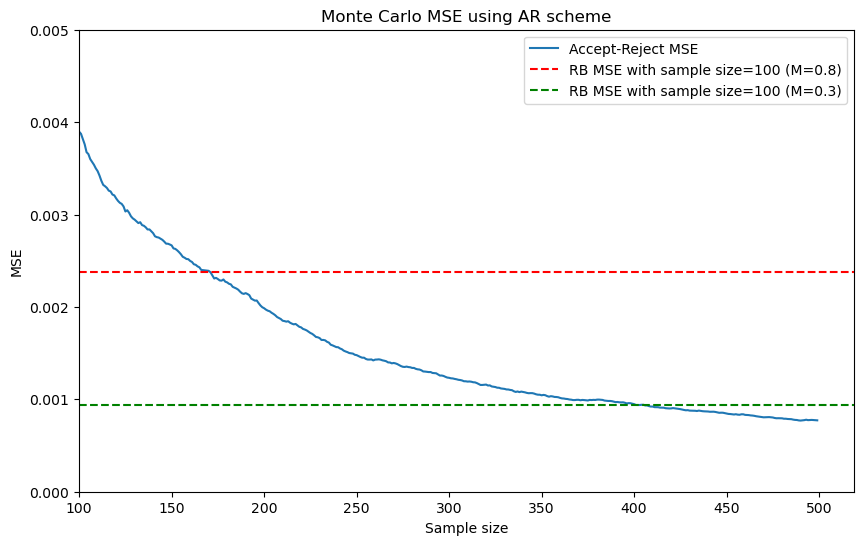

In [20]:
# Parameters :
tt = np.arange(100, 500, 1)
MSE = [0.00238, 0.00094]  # M values with corresponding Rao-Blackwell MSEs
true_mean = 1  
number_of_samples = 1000

mse_mh = np.zeros(len(tt))

for j in range(number_of_samples):
    accept, _ = Accept_Reject(tt[-1],1/0.8) 
    
    # For each t in tt, calculate MSE from the start of the chain up to t
    for i,t in enumerate(tt):
        subset_accept = accept[:t]
        MC_estimate = ((np.mean(subset_accept) - true_mean) ** 2)/number_of_samples
        mse_mh[i]+= MC_estimate

    # Progress indicator
    progress = 100 * (j + 1) / number_of_samples
    print(f"Progress: {progress:.2f}%".ljust(50), end='\r')

    
plt.figure(figsize=(10, 6))
plt.plot(tt, mse_mh, label=f'Accept-Reject MSE')
plt.axhline(y=MSE[0], color='red', linestyle='--', label=f'RB MSE with sample size=100 (M={0.8})')
plt.axhline(y=MSE[1], color='green', linestyle='--', label=f'RB MSE with sample size=100 (M={0.3})')
plt.legend()
plt.ylim(0, 0.005)
plt.xlim(100)
plt.xlabel('Sample size')
plt.ylabel('MSE')
plt.title(f"Monte Carlo MSE using AR scheme")
plt.show()


#### Computation time comparison for both estimator

In [22]:
# Parameters 
Ms = [1/0.8, 1/0.3]
size = [150, 400]
true_mean = 1 
number_of_samples = 1000  

results = []

# Classic MC
for s, M in zip(size, Ms):
    start_time = time.time()
    mse_classic_mc = 0  
    
    # Calculate mean for accepted samples and accumulate MSE
    for i in range(number_of_samples):
        accept, _ = Accept_Reject(s, M)
        temp = np.mean(accept)  
        mse_classic_mc += (temp - true_mean) ** 2  # Accumulate squared error
        
        print(f"Classic MC Progress (Size={s}, Rate={1/M}): {100 * (i + 1) / number_of_samples:.2f}%", end='\r')

    mse_classic_mc /= number_of_samples 
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples
    
    results.append({
        "Estimator": "Classic MC",
        "Size": s,
        "Acceptance rate": 1/M,
        "Time (s)": loop_time,
        "MSE": mse_classic_mc
    })
    print("")  

# Rao-Blackwell
for M in Ms:
    
    start_time = time.time()
    
    samples_proposal = []
    for _ in range(number_of_samples):
        accept, proposal = Accept_Reject(100, M)
        samples_proposal.append(proposal)

    
    res = []
    for j, sample in enumerate(samples_proposal):
        res.append(Rao_Blackwell_estimator_tau2(sample,100,M,f,g))
        print(f"Rao-Blackwell Progress (Rate={1/M}): {100 * (j + 1) / number_of_samples:.2f}%", end='\r')
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples   
    mse_rao_blackwell = np.mean((np.array(res) - true_mean)**2)

    
    results.append({
        "Estimator": "Rao-Blackwell",
        "Size": 100,  
        "Acceptance rate": 1/M,
        "Time (s)": loop_time,
        "MSE": mse_rao_blackwell
    })
    print("")  
print(" ")

results_df = pd.DataFrame(results)

df_rate_0_8 = results_df[results_df["Acceptance rate"] == 0.8].round(5)
df_rate_0_3 = results_df[results_df["Acceptance rate"] == 0.3].round(5)

print("Results for Acceptance rate = 0.8")
print(df_rate_0_8)
print("\nResults for Acceptance rate = 0.3")
print(df_rate_0_3)

Classic MC Progress (Size=150, Rate=0.8): 100.00%
Classic MC Progress (Size=400, Rate=0.3): 100.00%
Rao-Blackwell Progress (Rate=0.8): 100.00%
Rao-Blackwell Progress (Rate=0.3): 100.00%
 
Results for Acceptance rate = 0.8
       Estimator  Size  Acceptance rate  Time (s)      MSE
0     Classic MC   150              0.8   0.00048  0.00262
2  Rao-Blackwell   100              0.8   0.00644  0.00231

Results for Acceptance rate = 0.3
       Estimator  Size  Acceptance rate  Time (s)      MSE
1     Classic MC   400              0.3   0.00222  0.00090
3  Rao-Blackwell   100              0.3   0.04027  0.00084
